In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

import sys
from torch.utils.data import Subset
sys.path.append('/workspace/MRI-inpainting-project/data_scripts')

from datasets import TrainPatchesDataset, HealthyMRIDataset, PathologicalMRIDataset
from visualization_utils import ImageSliceViewer3D
import nibabel as nib


class DoubleConv3D(nn.Module):
    """Two consecutive 3D convolutional layers with ReLU activation."""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet3D, self).__init__()
        self.encoder_layers = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        for feature in features:
            self.encoder_layers.append(DoubleConv3D(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = DoubleConv3D(features[-1], features[-1]*2)
        
        self.up_transpose = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()
        reversed_features = features[::-1]
        decoder_in_channels = features[-1]*2  
        for feature in reversed_features:
            self.up_transpose.append(
                nn.ConvTranspose3d(decoder_in_channels, feature, kernel_size=2, stride=2)
            )
            self.decoder_layers.append(DoubleConv3D(feature*2, feature))
            decoder_in_channels = feature  
        
        self.conv_final = nn.Conv3d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for encoder in self.encoder_layers:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        
        for idx in range(len(self.up_transpose)):
            x = self.up_transpose[idx](x)
            skip_connection = skip_connections[idx]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_layers[idx](x)
        
        x = self.conv_final(x)
        return torch.sigmoid(x)  


class MRIDataset(Dataset):
    def __init__(self, mri_data):
        self.data = mri_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mri = self.data[idx]['patch'].astype(np.float32)
        mask = self.data[idx]['mask'].astype(np.float32)
        prob_mask = self.data[idx]['prob_mask'].astype(np.float32)

        return torch.tensor(mri).unsqueeze(0), torch.tensor(prob_mask).unsqueeze(0), torch.tensor(mask).unsqueeze(0)


class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, preds, targets):
        preds = preds.contiguous()
        targets = targets.contiguous()
        
        intersection = (preds * targets).sum(dim=(2,3,4))
        dice = (2. * intersection + self.smooth) / (preds.sum(dim=(2,3,4)) + targets.sum(dim=(2,3,4)) + self.smooth)
        return 1 - dice.mean()

In [52]:
train_patches = TrainPatchesDataset("/workspace/MRI-inpainting-project/data/train_patches_v3")
healthy_data = HealthyMRIDataset('/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_mri_t1',
                                 '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/masks',
                                 '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/patch_masks')

train_ids = np.arange(0, len(train_patches) - 10)
val_ids = np.arange(len(train_patches) - 10, len(train_patches))
train_dataset = MRIDataset(train_patches)
val_dataset = MRIDataset(Subset(train_patches, val_ids))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [41]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Create an experiment with your api key
experiment = Experiment("lVHrwe9BODgMYV1xca8QoEYs8")


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pavelbartenev/general/20ce06a19c0f426aad66e0074e624f49



In [54]:
def train_model(model, criterion, optimizer, num_epochs, weight_decay, cond=False):
    val_losses = []
    train_losses = []
    step_counter = 0  
    log_name_suff = f"_{weight_decay}_cond" if cond else f"_{weight_decay}"
    
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        
        for batch_idx, (inputs, prob_mask, masks) in enumerate(loop):
            inputs = inputs.to(device)
            masks = masks.to(device)

            if cond:
                prob_mask = prob_mask.to(device)
                inputs = torch.cat((inputs, masks), dim=1)
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
            experiment.log_metric("train_loss" + log_name_suff, loss.item(), step=step_counter, epoch=epoch)
            step_counter += 1

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        experiment.log_metric("avg_train_loss" + log_name_suff, avg_loss, step=epoch, epoch=epoch)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, prob_mask, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                if cond:
                    prob_mask = prob_mask.to(device)
                    inputs = torch.cat((inputs, masks), dim=1)
                
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Optionally log validation loss per batch
                experiment.log_metric("val_loss" + log_name_suff, loss.item(), step=step_counter, epoch=epoch)
                step_counter += 1
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Log average validation loss per epoch
        experiment.log_metric("avg_val_loss" + log_name_suff, avg_val_loss, step=epoch, epoch=epoch)
    
        # Plotting
        clear_output()
        plt.figure()
        plt.plot(train_losses, label='train loss')
        plt.title('Train')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.plot(val_losses, label='val loss')
        plt.title('Validation')
        plt.legend()
        plt.show()
    
    model_path = f'unet3d_{weight_decay}.pth'
    torch.save(model.state_dict(), model_path)

    return train_losses, val_losses

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
experiment.set_name("3DUnet")

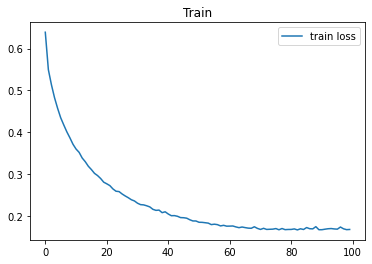

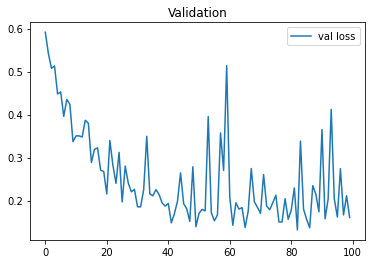

In [46]:
num_epochs = 100
weight_decay_grid = [0, 0.01, 0.05, 0.1]

for weight_decay in weight_decay_grid:
    model = UNet3D(in_channels=1, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
    train_model(model, criterion, optimizer, num_epochs, weight_decay)

In [47]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 3DUnet
COMET INFO:     url                   : https://www.comet.com/pavelbartenev/general/20ce06a19c0f426aad66e0074e624f49
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss_0 [100]    : (-0.01818833812031635, 0.5595067871171374)
COMET INFO:     avg_train_loss_0.01 [100] : (0.09584747168213822, 0.649262762346933)
COMET INFO:     avg_train_loss_0.05 [100] : (0.13845337892687598, 0.5395664531131124)
COMET INFO:     avg_train_loss_0.1 [100]  : (0.1671458902054055, 0.6388248676477477)
COMET INFO:     avg_val_loss_0 [100]      : (0.02561888036628564, 0.5013842781384786)
COMET INFO:     avg_val_loss_0.01 [100]   : (0.0706409861644109

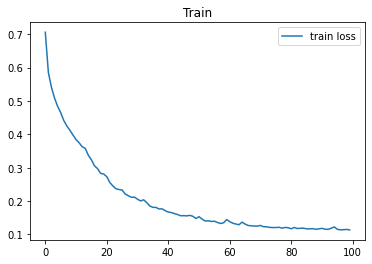

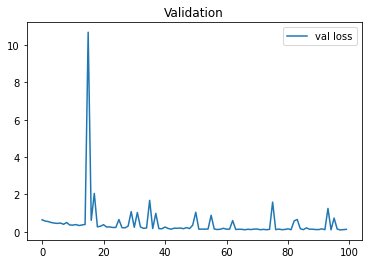

In [60]:
experiment = Experiment("lVHrwe9BODgMYV1xca8QoEYs8")
experiment.set_name("3DUnet_cond")


num_epochs = 100
weight_decay_grid = [0, 0.01, 0.05, 0.1]

for weight_decay in weight_decay_grid:
    model = UNet3D(in_channels=2, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
    train_model(model, criterion, optimizer, num_epochs, weight_decay, cond=True)

In [61]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 3DUnet_cond
COMET INFO:     url                   : https://www.comet.com/pavelbartenev/general/422a68e55329423f874e563f9ea4e8d9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss_0.01_cond [100] : (0.03251502896810687, 0.5525188951991326)
COMET INFO:     avg_train_loss_0.05_cond [100] : (0.07180866928294648, 0.6345590657966081)
COMET INFO:     avg_train_loss_0.1_cond [100]  : (0.11369405426951341, 0.7057426253030467)
COMET INFO:     avg_train_loss_0_cond [100]    : (-0.08808803653647733, 0.6152537894803424)
COMET INFO:     avg_val_loss_0.01_cond [100]   : (0.03529748817284902, 3.018494447072347)
COMET INFO:     avg_val_loss_0.0

### Mask generation

In [136]:
new_mask_volume = []
new_masks = []
for sample in tqdm(healthy_data):
    mri = sample['mri']
    patch_mask = sample['patch_mask']

    patch = mri[patch_mask > 0].reshape(1, 40, 40, 40)
    patch = torch.tensor(patch.astype(np.float32))

    gen_mask = model(patch.unsqueeze(0).to(device)).cpu().detach().numpy()
    gen_mask = (gen_mask > 0.5).astype(np.float64)

    new_mask = np.zeros_like(mri)
    new_mask[patch_mask > 0.5] = gen_mask.flatten() 

    new_mask_volume.append(np.sum(new_mask))
    new_masks.append(new_mask)

    nib_mask = nib.Nifti1Image(new_mask, affine=np.eye(4))
    maskname = sample['filename'].split('.')[0] + "-mask.nii.gz"
    nib.save(nib_mask, f"/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/3dunet_masks/masks/{maskname}")

100%|██████████| 77/77 [01:13<00:00,  1.04it/s]


### Model interpretation

In [52]:
model.eval()

sample = val_dataset[0]

output = model(sample[0].unsqueeze(0).to(device))

In [ ]:
!pip install captum

In [9]:
sample = val_dataset[0]
input = sample[0].unsqueeze(0).to(device)
input.requires_grad = True

In [17]:
from captum.attr import IntegratedGradients

baseline = torch.zeros_like(input)

def forward_func(x):
    return model(x).sum().reshape(1, 1)

ig = IntegratedGradients(forward_func)

attributions, delta = ig.attribute(input, 
                                   baselines=baseline, 
                                   target=None,  
                                   return_convergence_delta=True,
                                   n_steps=50)

attributions = attributions.detach().cpu().numpy()[0, 0] 

In [19]:
attributions_norm = (attributions - attributions.min()) / (attributions.max() - attributions.min())

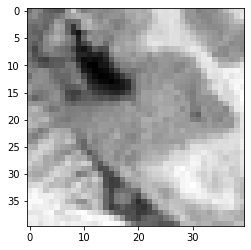

In [30]:
plt.imshow(input[0, 0, :, :, 10].detach().cpu().numpy(), cmap='gray')

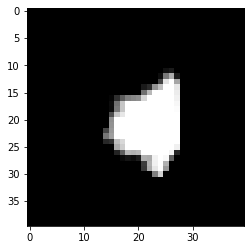

In [29]:
plt.imshow(sample[1][0, :, :, 10], cmap='gray')

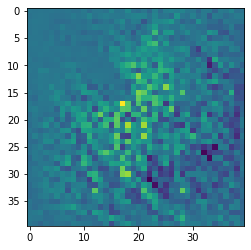

In [31]:
plt.imshow(attributions_norm[:, :, 10])